Author: Jonathan Gong

In [1]:
import pandas as pd
import os
import sys
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np


# TODO 
- interpolate data so the bgl level readings are recorded at equal time intervals

# Data processing

In [2]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}'))

C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\895166927.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_files.append(pd.read_csv(f'../data/raw/{file}'))


In [3]:
each_bgl =[]
for file in csv_files:
    each_df = file[["date", "bgl", "msg_type"]]
    each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    each_df.dropna(subset=['date'], inplace = True)
    each_df.dropna(subset=["bgl"], inplace = True)
    each_df["msg_type"] = [
    1 if i == 'ANNOUNCE_EXERCISE' else 2 if i == 'ANNOUNCE_MEAL' else 0
    for i in each_df["msg_type"]
    ]
    each_df.sort_values('date', inplace = True)
    each_df.drop_duplicates(subset=['date'], inplace = True)
    # each_df.set_index('date', inplace=True)
    each_bgl.append(each_df)

C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\2187542184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\2187542184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df.dropna(subset=['date'], inplace = True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\2187542184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [4]:
days_patients = []
for bgl in each_bgl:
    # (hour:minute:second)
    bgl['time'] = bgl['date'].dt.time
    # (year-month-day)
    bgl['day'] = bgl['date'].dt.date
    # unique days
    unique_days = bgl['day'].unique()
    day_data = []
    for i, day in enumerate(unique_days):
        bgl_day = bgl[bgl['day'] == day]
        day_data.append(bgl_day[["date", "bgl"]])

    days_patients.append(day_data)

C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\1387374491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgl['time'] = bgl['date'].dt.time
C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\1387374491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgl['day'] = bgl['date'].dt.date
C:\Users\jonat\AppData\Local\Temp\ipykernel_32068\1387374491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [5]:
for patient_days in days_patients:
    for df in patient_days:
        df.set_index('date', inplace=True)

In [6]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [25]:
Y_0 = each_bgl[0][["msg_type"]]
Y_1 = each_bgl[1][["msg_type"]]

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_days_patient_0)

In [9]:
from sklearn.cluster import KMeans
data_used = all_days_patient_0
n_components = 2 # Number of components in the GMMHMM
kmeans = KMeans(n_clusters=n_components).fit(data_used)
initial_means = kmeans.cluster_centers_

c:\Users\jonat\Documents\Code\WAT.ai\bg_control-1\0_meal_identification\meal_identification\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jonat\Documents\Code\WAT.ai\bg_control-1\0_meal_identification\meal_identification\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1

In [10]:
initial_means

array([[ 95.67453803],
       [160.85585277]])

# Model training and eval

In [58]:
def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y = "bruh"):
    if not supervised:
        model = GMMHMM(n_components=n_components, n_mix=n_mix, n_iter=n_iter, covariance_type = 'full',  verbose = True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        model.fit(X)
        return model
    else:
        model = GMMHMM(n_mix=n_mix, n_iter=n_iter, covariance_type = 'full', verbose=True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        print("supervised")
        model.fit_predict(X = X, Y = Y)
        return model

In [12]:
n_components = 2
model = runGMMHMM(supervised= False, n_components=n_components, X = all_days_patient_0, n_mix = 2, n_iter = 100)


         1 -175432.53709754             +nan
         2 -146862.53535792  +28570.00173962
         3 -150693.66944411   -3831.13408619
Model is not converging.  Current: -150693.66944411144 is not greater than -146862.53535791882. Delta is -3831.1340861926146


In [13]:
hidden_states = model.predict(pd.concat(days_patients[0][0:7]))

In [14]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0])

In [15]:
len(hidden_states)

1930

In [16]:
hidden_states

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
data_used.index, hidden_states

(DatetimeIndex(['2024-07-01 05:02:39+00:00', '2024-07-01 05:07:39+00:00',
                '2024-07-01 05:12:39+00:00', '2024-07-01 05:17:39+00:00',
                '2024-07-01 05:22:40+00:00', '2024-07-01 05:27:40+00:00',
                '2024-07-01 05:32:40+00:00', '2024-07-01 05:37:40+00:00',
                '2024-07-01 05:42:40+00:00', '2024-07-01 05:47:40+00:00',
                ...
                '2024-10-01 04:32:41+00:00', '2024-10-01 04:36:40+00:00',
                '2024-10-01 04:39:40+00:00', '2024-10-01 04:42:37+00:00',
                '2024-10-01 04:45:37+00:00', '2024-10-01 04:47:37+00:00',
                '2024-10-01 04:49:38+00:00', '2024-10-01 04:53:37+00:00',
                '2024-10-01 04:55:38+00:00', '2024-10-01 04:57:37+00:00'],
               dtype='datetime64[ns, UTC]', length=32505, freq=None),
 array([0, 0, 0, ..., 0, 0, 0]))

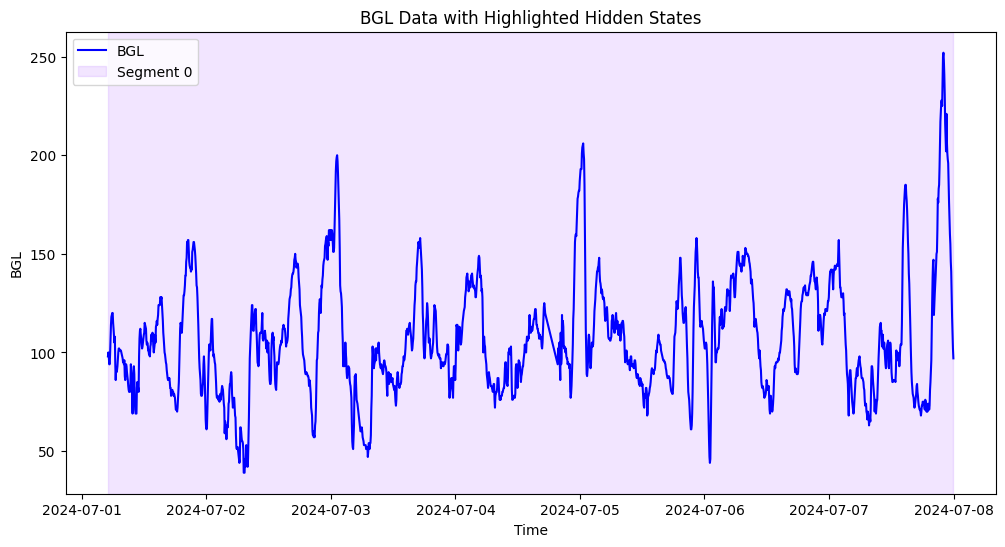

In [18]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = pd.concat(days_patients[0][0:7])
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(Y_0)

In [59]:
n_components = 4
model = runGMMHMM(supervised= True, n_components=n_components, X = all_days_patient_0, n_mix = 16, n_iter = 100, Y = Y_0)

supervised


         1 -171136.01181571             +nan
         2 -160179.83606036  +10956.17575536
         3 -159487.51887049    +692.31718987
         4 -159328.42528569    +159.09358480
         5 -159254.63841913     +73.78686656
         6 -159207.02856613     +47.60985300
         7 -159169.65160789     +37.37695824
         8 -159137.06315164     +32.58845625
         9 -159107.14446616     +29.91868547
        10 -159078.96176239     +28.18270378
        11 -159052.06458413     +26.89717826
        12 -159026.24100203     +25.82358210
        13 -159001.42094695     +24.82005507
        14 -158977.62839013     +23.79255682
        15 -158954.95006471     +22.67832542
        16 -158933.51000409     +21.44006062
        17 -158913.44657339     +20.06343070
        18 -158894.89156896     +18.55500443
        19 -158877.95220818     +16.93936078
        20 -158862.69725722     +15.25495097
        21 -158849.14841564     +13.54884158
        22 -158837.27754227     +11.87087337
        23

In [60]:
hidden_states = model.predict(pd.concat(days_patients[0][0:7]))

In [61]:
np.unique(hidden_states)

array([0])

In [62]:
model

GMMHMM(covariance_type='full', n_iter=100, n_mix=16, verbose=True)

1930


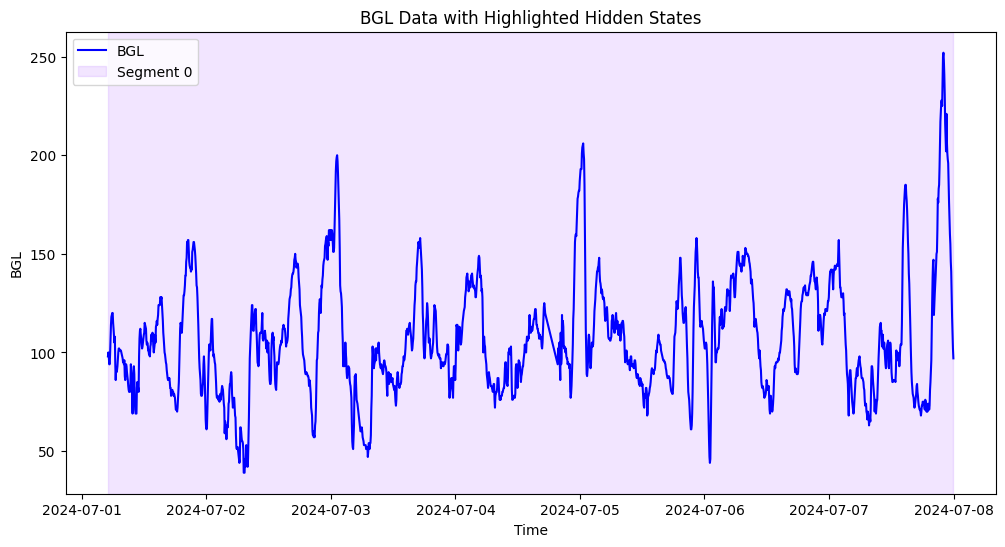

In [63]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = pd.concat(days_patients[0][0:7])
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    print(len(masks))
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()